# Creating the Vocabulary

In [1]:
import spacy
spacy_eng = spacy.load("en_core_web_sm")
class Vocabulary:
    PAD_token = 0   # Used for padding short sentences
    SOS_token = 1   # Start-of-sentence token
    EOS_token = 2   # End-of-sentence token

    def __init__(self, name):
        self.name = name
        self.word2index = {'PAD': 0, 'SOS': 1, 'EOS': 2, 'UNK':3}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS", 3: "UNK"}
        self.num_words = 4
        self.num_sentences = 0 
        self.longest_sentence = 0
    


    def add_word(self, word):
        
        if word not in self.word2count:
            # First entry of word into vocabulary
            self.word2count[word] = 1
        else:
            if self.word2count[word]== 5:
                self.word2index[word] = self.num_words
                self.index2word[self.num_words] = word
                self.num_words += 1
                self.word2count[word] +=1
            else:
                self.word2count[word] += 1
        
    def tokenizer(self,text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]
    
    def add_sentence(self, sentence):
        sentence_len = 0
        #for word in sentence.split(' '):
        for word in self.tokenizer(sentence):
            sentence_len += 1
            self.add_word(word)
        if sentence_len > self.longest_sentence:
            # This is the longest sentence
            self.longest_sentence = sentence_len
        # Count the number of sentences
        self.num_sentences += 1

    def to_word(self, index):
        return self.index2word[index]

    def to_index(self, word):
        return self.word2index[word]

In [2]:
import pandas as pd
import re
df = pd.read_csv('flickr30k_images/results.csv',delimiter='|')
df[' comment'] = df[' comment'].str.lower()
df[' comment'].replace( { r'[^a-zA-Z0-9, ]' : '' }, inplace= True, regex = True)

# fixing an issue in the dataset.
df[' comment_number'][19999] = 4
df[' comment'][19999] = ' a dog runs across the grass '

# creating the vocabulary 
vocab = Vocabulary('test')

# adding words to the vocabulary 
for sentence in df[' comment']:
    vocab.add_sentence(sentence)

# converting the captions to tokens 
sent_idxs = []
captions = []
for idx, sentence in enumerate (df[' comment']):
    i = 0
    
    for word in vocab.tokenizer(sentence):
        if word not in vocab.word2index:
            sent_idxs.append(3)
        else:
            sent_idxs.append(vocab.to_index(word))
        i+=1
    while i < ((vocab.longest_sentence) + 1):
        sent_idxs.append(0)
        i+=1
    captions.append(sent_idxs)
    sent_idxs = []

# converting list of word tokens to numpy array
import numpy as np
captions = np.array(captions)
captions.shape

(158915, 83)

In [3]:
# adding start and end tokens
for i in range(len(captions)):
    for j in range(1,84):
        if captions[i,j] == 0:
            if captions[i,j-1] == 4:
                captions[i,j-1] = 2
            else:
                captions[i,j] = 2
            break  
captions[:,0] = 1

In [4]:
vocab.num_words

7075

# Loading the embeddings

In [5]:
import numpy as np 
vocabs = vocab.word2index.keys()

def load_embeds(root_dir):
    embeddings_index = dict()
    f = open(root_dir,encoding="utf8")

    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

    f.close()
    return embeddings_index
embeddings_index = load_embeds('flickr30k_images/glove.6B.300d.txt')

In [6]:
embeddings_index['the']

array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-02,  4.14

In [7]:
import torch
def load_embed_weights(embeddings_index, embed_dim, vocab, vocab_size):
    matrix_len = vocab_size
    weights_matrix = np.zeros((matrix_len, embed_dim))
    words_found = 0

    for i, word in enumerate(vocab):
        try: 
            weights_matrix[i] = embeddings_index[word]
            words_found += 1
        except KeyError:
            weights_matrix[i] = np.random.normal(scale=0.6, size=(embed_dim, ))
    weights_matrix = torch.tensor(weights_matrix)
    return weights_matrix
weights_matrix = load_embed_weights(embeddings_index, 300, vocabs, vocab.num_words)
weights_matrix.shape

torch.Size([7075, 300])

# Some helper functions which we will be using later

In [8]:
def output_to_caption(outputs, index):
    preds = outputs[index]
    preds = torch.argmax(preds, dim = 1)
    preds = preds.cpu()
    preds = np.array(preds)
    for index in preds:
        if index == 2:
            break    
        if index != 1:    
            print(vocab.to_word(index), end = ' ')

def tensor_to_caption(preds, index):
    preds = preds[index].cpu()
    preds = np.array(preds)
    for index in preds:
        if index == 2:
            break
        if index != 1:    
            print(vocab.to_word(index), end = ' ')

def tensor_to_image(img_list, index):
    img = img_list[index].permute(1,2,0)
    plt.figure()
    plt.imshow(img.cpu())

a man in a black coat walks past a red UNK with a parking ticket stuck to its window 

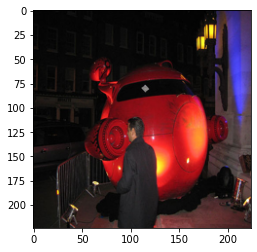

In [9]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from glob import glob
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class Data(Dataset):

    def __init__(self, root_dir, captions):
        
        self.root_dir = root_dir
        self.df = pd.read_csv(root_dir+'results.csv', delimiter = '|')
        self.captions_tensor = torch.tensor(captions)
        self.captions = captions
        self.imgloc = self.df['image_name']
        self.img_list = glob(root_dir+'flickr30k_images/*')
    
    def __getcaption__(self,index):
        return self.captions[5*index]
    
    def __getitem__(self,index):
        
        img = self.root_dir+'flickr30k_images/'+ self.imgloc[5*index]
        caption = self.captions[5*index]
        img_tensor = (torch.tensor(np.array(Image.open(img).resize((224,224)))).permute(2,0,1) )/255
        return img_tensor, caption
    
    def __len__(self):
        return (len(self.img_list)-2)


data = Data('flickr30k_images/', captions)
img, caption_tensor = data.__getitem__(69)
caption = data.__getcaption__(69)
plt.imshow(img.permute(1,2,0))
for idx in caption:
    if idx == 1:
        continue
    if idx !=2:
        print(vocab.to_word(idx), end =" ")
    else:
        break

two people dressed up in white sheets and pink gloves stare at a snow covered glacier off in the distance 

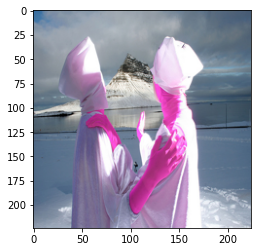

In [10]:
batch_size = 32
data_len = len(data)
trainset, valset = random_split(data, [int(0.8*data_len), (data_len - int(0.8*data_len))])
trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle = True)
valloader = DataLoader(dataset=valset, batch_size=batch_size, shuffle = True)
for img_list, caption in trainloader:
    plt.imshow(img_list[4].permute(1,2,0))
    tensor_to_caption(caption,4)
    break


# Encoder

In [11]:
import torchvision
import torch.nn as  nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from glob import glob
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet50(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model = torch.nn.Sequential(*(list(self.model.children())[:-2]))
    def forward(self, x):
        return self.model(x)

encoder = Encoder()

# Attention (soft)

In [12]:
class attention(nn.Module):
  def __init__(self, feature_dim, hidden_dim, embed_dim, num_vecs):
    super().__init__()
    
    self.features_fc = nn.Linear(feature_dim, num_vecs)
    self.hidden_fc = nn.Linear(hidden_dim, num_vecs)
    self.context_fc = nn.Linear(num_vecs, 1)
    self.input_fc = nn.Linear(embed_dim, hidden_dim)
    self.hidden_gate_fc = nn.Linear(hidden_dim, hidden_dim)
    self.s_fc = nn.Linear(hidden_dim, num_vecs)
    self.ones = torch.ones(num_vecs,1).to(device)
    self.tanh = torch.tanh
    self.sigma = torch.sigmoid
  
  def forward(self, features, hidden, inputs, memory):

    c1 = []
    #c1 = c1.to(device)
    for i in range(features.shape[0]):
      f = self.features_fc(features[i,:,:])            #3,3
      h = self.hidden_fc(hidden[i,:].unsqueeze(0))     #1,3
      h1 = self.ones @ h
      c = self.tanh(f+h1)                               #3,3
      z = self.context_fc(c).permute((1,0))            #1,3
      a = F.softmax(z, dim = 1)
      test = a @ features[i,:,:]

    
      gate = self.sigma( self.input_fc(inputs[i,:]) + self.hidden_gate_fc(hidden[i,:]) )
      s = gate * self.tanh(memory[i,:])                
  
      ws = self.s_fc(s.unsqueeze(0))                   #1,3
      
      w = self.tanh(ws+h)                              #1,3
      i = self.context_fc(w)                           
      
      concat = F.softmax(torch.cat((z,i), dim = 1), dim = 1).squeeze(0)
      b = concat[-1]
  
      c1b = b*s + (1-b)*(test)
      c1.append(c1b)


    c1 = torch.stack(c1)

    return  c1.squeeze(1)


# Decoder

In [13]:
class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, weights_matrix, device, num_layers=1):
        super(Decoder, self).__init__()
        
        # define the properties
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        
        # lstm cell
        #self.lstm_cell = nn.LSTMCell(input_size = embed_size + hidden_size, hidden_size=hidden_size)
        self.lstm_cell = nn.LSTMCell(input_size = embed_size, hidden_size=hidden_size)
        # output fully connected layer
        self.fc_out = nn.Linear(in_features = self.hidden_size*2, out_features = self.vocab_size)
    
        # embedding layer
        self.embed = nn.Embedding(num_embeddings = self.vocab_size, embedding_dim = self.embed_size)
        self.embed.weight.requires_grad = False
        self.embed.load_state_dict({'weight': weights_matrix})

        self.attn = attention(2048, 2048, 300, 49)
        
        #self.embed_test = nn.Embedding(num_embeddings = self.vocab_size, embedding_dim = self.embed_size)
        #self.embed_test.weight.requires_grad = False
        #self.embed_test.load_state_dict({'weight': weights_matrix})
         
    def forward(self, features, captions, test = False):


        # features = [32,196,512], captions = [32,num_words]
        
        # batch size
        batch_size = features.size(0)    # 32
        
        # init the hidden and cell states to zeros
        
        #hidden_state = torch.zeros((batch_size, self.hidden_size)).to(device)    #[32,512]
        #cell_state = torch.zeros((batch_size, self.hidden_size)).to(device)      #[32,512]
        
        hidden_state = torch.mean(features, dim = 1)    #[32,512]
        cell_state = torch.mean(features, dim = 1)      #[32,512]
        states = (hidden_state, cell_state)
        outputs = torch.empty((batch_size, captions.size(1), self.vocab_size)).to(device) #captions.size(1) is the number of words 
        # outputs = [32,num_words,vocab_size]
        
        # embed the captions
        captions_embed = self.embed(captions)    #[32,num_words,300]
        
        # pass the caption word by word
        if test == False: 
            for t in range(captions.size(1)):

                # getting the features of the image to be focussed on  
                #context = attn(features, hidden_state)  #[32,512]

                # concatnating it with the input word
                #inputs = torch.cat((context, captions_embed[:, t, :]), dim = 1) # [32,812] 

                #passing the combination through lstm
                #hidden_state, cell_state = self.lstm_cell(inputs, (hidden_state, cell_state))
                hidden_state, cell_state = self.lstm_cell(captions_embed[:,t,:], (hidden_state, cell_state))


                context = self.attn(features, hidden_state, captions_embed[:,t,:], cell_state)

                out = torch.cat((context, hidden_state), dim = 1)
                # output of the attention mechanism
                out = self.fc_out(out)

                # build the output tensor
                outputs[:, t, :] = out      

            return F.log_softmax(outputs, dim = 2)
        
        

        
    
        else:
            
            word_idxs = torch.ones(batch_size).long().to(device)
            
            
            for i in range(captions.size(1)):
                
                word_embeds = self.embed(word_idxs)     #[32,300]
            
                
                hidden_state, cell_state = self.lstm_cell(word_embeds, (hidden_state, cell_state))


                context = self.attn(features, hidden_state, word_embeds, cell_state)

                out = torch.cat((context, hidden_state), dim = 1)
                # output of the attention mechanism
                out = self.fc_out(out)
            
                # build the output tensor
                outputs[:, i, :] = out
                
                word_idxs = torch.argmax(out, dim = 1)
                

            return F.log_softmax(outputs, dim = 2)

              
            
        
        
        
vocab_size = vocab.num_words
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
decoder = Decoder(300,2048, vocab_size,weights_matrix, device)

In [14]:
encoder.to(device)
decoder.to(device)
decoder.load_state_dict(torch.load('weights/final_run3.pth'))

<All keys matched successfully>

In [15]:
for idx, (img_list, caption) in enumerate (trainloader):

        img_list = img_list.to(device)
        caption_target = caption[:,1:]    # skips SOS
        caption_train = caption[:,:-1]    # skips EOS
        caption_target, caption_train = caption_target.to(device).long(), caption_train.to(device).long()
        features = encoder(img_list) # [32,512,49,49]
        features = features.permute(0,2,3,1)    # [32,7,7,2048]
        features = features.view(-1, 49, 2048) # [32,196,512]
        outputs = decoder(features, caption_train)
        preds = outputs[0]
        ################################################ converting the predictions to words ######################################################################
        preds = torch.argmax(preds, dim = 1)
        preds = preds.cpu()
        preds = np.array(preds)
        ans = []
        for index in preds:
                if index == 2:
                        break    
                if index != 1:    
                        ans.append(vocab.to_word(index))
        s = 'GREEDY DECODING: '
        for word in ans:
                s+=word
                s+=" "
        plt.imshow()

C:\Users\abhip\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


TypeError: imshow() missing 1 required positional argument: 'X'

In [16]:
import torch
import numpy as np
from PIL import Image
import io
import datetime
import base64
import dash
from dash.dependencies import Input, Output, State
import dash_core_components as dcc
import dash_html_components as html


external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div([
    html.H1(id = 'H1', children = 'Image Captioning', style = {'textAlign':'center',\
                                            'marginTop':40,'marginBottom':40}),
    dcc.Upload(
        id='upload-image',
        children=html.Div([
            'Drag and Drop or ',
            html.A('Select Files')
        ]),
        style={
            'width': '100%',
            'height': '60px',
            'lineHeight': '60px',
            'borderWidth': '1px',
            'borderStyle': 'dashed',
            'borderRadius': '5px',
            'textAlign': 'center',
            'margin': '10px'
        },
        # Allow multiple files to be uploaded
        multiple=True
    ),
    html.Div(id='greedy'),
    #html.Div(id='beamsearch')
])


def parse_contents(contents, filename, date):
    

    ##############################################  converting image to tensor ##############################################################################
    image = base64.b64decode(contents[23:])
    image = torch.tensor(np.array(Image.open(io.BytesIO(image)).resize((224,224)))).permute(2,0,1)/255

    image = image.to(device)
    image = image.unsqueeze(0)
    captions_train = torch.randint(0,1000,(1,82)).to(device)

    ############################################### passing the image through the model ######################################################################
    features = encoder(image) 
    features = features.permute(0,2,3,1)    
    features = features.view(-1, 49, 2048) 
    outputs1 = decoder(features, captions_train, test = True)   
    preds = outputs1[0]
    ################################################ converting the predictions to words ######################################################################
    preds = torch.argmax(preds, dim = 1)
    preds = preds.cpu()
    preds = np.array(preds)
    ans = []
    for index in preds:
        if index == 2:
            break    
        if index != 1:    
            ans.append(vocab.to_word(index))
    s = 'GREEDY DECODING: '
    for word in ans:
        s+=word
        s+=" "
    #ans1 = beam_search(image.squeeze(0))
    #s+= "\n BEAM SEARCH: "
    #for word in ans1:
    #    s+=word
    #    s+=" "



    return s
    

@app.callback(Output('greedy', 'children'),
              Input('upload-image', 'contents'),
              State('upload-image', 'filename'),
              State('upload-image', 'last_modified'))
def update_output(list_of_contents, list_of_names, list_of_dates):
    if list_of_contents is not None:        
        children = [
            parse_contents(c, n, d) for c, n, d in
            zip(list_of_contents, list_of_names, list_of_dates)]
        return children


if __name__ == '__main__':
    app.run_server()


Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [25/Oct/2021 18:18:13] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/Oct/2021 18:18:14] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [25/Oct/2021 18:18:14] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [25/Oct/2021 18:18:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [25/Oct/2021 18:18:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [25/Oct/2021 18:18:41] "POST /_dash-update-component HTTP/1.1" 200 -
